In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../../data/ozone.csv')
df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


ERROR! Session/line number was not unique in database. History logging moved to new session 272


### 필요없는 컬럼 삭제

In [48]:
df.drop(['Month', 'Day'], axis=1, inplace=True)

In [49]:
df.describe()

,Ozone,Solar.R,Wind,Temp
count,116.000000,146.000000,153.000000,153.000000
mean,42.129310,185.931507,9.957516,77.882353
std,32.987885,90.058422,3.523001,9.465270
min,1.000000,7.000000,1.700000,56.000000
25%,18.000000,115.750000,7.400000,72.000000
50%,31.500000,205.000000,9.700000,79.000000
75%,63.250000,258.750000,11.500000,85.000000
max,168.000000,334.000000,20.700000,97.000000


### 결측치 처리 - 제거

In [50]:
df.dropna(how='any', inplace=True)

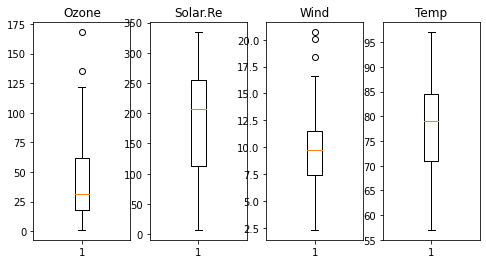

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4))
ax[0].boxplot(df['Ozone'])
ax[0].set_title('Ozone')

ax[1].boxplot(df['Solar.R'])
ax[1].set_title('Solar.Re')

ax[2].boxplot(df['Wind'])
ax[2].set_title('Wind')

ax[3].boxplot(df['Temp'])
ax[3].set_title('Temp')
plt.show()

In [52]:
from scipy import stats
zscore_threshold = 2.0
outlier_col = ['Ozone', 'Wind']

for col in outlier_col:
    outlier = df[col][(np.abs(stats.zscore(df[col])) > zscore_threshold)]
    df_ozone = df.loc[np.isin(df[col], outlier, invert=True)]

In [53]:
df_ozone.describe()

,Ozone,Solar.R,Wind,Temp
count,106.000000,106.000000,106.000000,106.000000
mean,41.801887,186.075472,9.801887,77.905660
std,32.745024,90.681725,3.071156,9.127174
min,1.000000,7.000000,3.400000,58.000000
25%,18.000000,115.750000,7.400000,71.250000
50%,30.500000,209.500000,9.700000,79.000000
75%,60.500000,255.750000,11.500000,84.000000
max,168.000000,334.000000,16.600000,97.000000


### 학습데이터

In [54]:
X_train = df_ozone.iloc[:, 1:]
y_train = df_ozone['Ozone'].values.reshape(-1, 1)

### 파이썬

In [55]:
def get_numerical_derivative(f, x):
    
    delta_x = 1e-4
    derivative_x = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    
    while not it.finished:
        idx = it.multi_index
        tmp = x[idx]
        
        x[idx] = tmp + delta_x
        fx_plus_delta = f(x)
        
        x[idx] = tmp - delta_x
        fx_minus_delta = f(x)
        
        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)
        
        x[idx] = tmp
        it.iternext()
    return derivative_x

### MinMax

In [56]:
def min_max(data):
    return (data - data.min()) / (data.max() - data.min())

In [57]:
df_ozone_python = df_ozone.apply(min_max)

In [58]:
X_train_py = df_ozone_python.iloc[:, 1:]
y_train_py = df_ozone_python['Ozone'].values.reshape(-1, 1)

In [59]:
W = np.random.rand(3, 1)
b = np.random.rand(1)

In [60]:
def loss_func(input_data):
    W = input_data[:-1].reshape(-1,1)
    b = input_data[-1:]
    
    y = np.dot(X_train_py,W) + b
    return np.mean(np.power(y_train_py-y,2))

def predict(x):
    y = np.dot(x,W) + b
    return y

learning_rate = 1e-2

for step in range(30000):
    
    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
    derivative_result = learning_rate * get_numerical_derivative(loss_func, input_param)

    W = W - derivative_result[:-1].reshape(-1,1)
    b = b - derivative_result[-1]

In [64]:
a = np.array([[150.0,10.0,80.0]])
pred = predict(min_max(a))
pred

array([[0.46118649]])

In [62]:
min_max(a)

array([[1. , 0. , 0.5]])

### 사이킷런

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit(X_train).transform(X_train)
y_train_scaled = scaler.fit(y_train).transform(y_train)

lr_clf = LinearRegression()
lr_clf.fit(X_train_scaled, y_train_scaled)
array = np.array([[150.0,10.0,80.0]])
test = scaler.fit(array).transform(array)
pred = lr_clf.predict(np.array([[150.0,10.0,80.0]]))
pred

array([[46.39304383]])

In [42]:
test

array([[0., 0., 0.]])

In [43]:
X_train_scaled.shape, y_train_scaled.shape

((106, 3), (106, 1))

In [44]:
import tensorflow as tf

X = tf.placeholder(shape=[None, 3], dtype=tf.float32)
T = tf.placeholder(shape=[None, 1], dtype=tf.float32)

W = tf.Variable(tf.random.normal([3,1]))
b = tf.Variable(tf.random.normal([1]))

H = tf.matmul(X,W) + b

loss = tf.reduce_mean(tf.square(H-T))

model = tf.train.GradientDescentOptimizer(learning_rate = 1e-2).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(30000):
    _, W_val, b_val, loss_val = sess.run([model, W, b, loss], feed_dict={X: X_train_scaled,
                                                                         T: y_train_scaled})

In [45]:
pred = sess.run(H, feed_dict={X:np.array([[150.0,10.0,80.0]])})
pred

array([[46.390335]], dtype=float32)

In [46]:
loss_val

0.01434793